In [156]:
import os
import json
from globals import BASE_DIR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [157]:
# Define the datasets you want to process
available_datasets = ["brightkite", "foursquaretky", "gowalla", "snowcard", "yelp"]

data = []
for dataset in available_datasets:
    recs = os.listdir(f"{BASE_DIR}{dataset}_dataset/recommendations")
    if '.DS_Store' in recs:
        recs.remove('.DS_Store')
    

    for dir in recs:
        print(dir)
        json_file = f"{BASE_DIR}{dataset}_dataset/recommendations/{dir}/general_evaluation.json"
        
        # Load the JSON data
        with open(json_file, 'r') as f:
            eval_data = json.load(f)
        
        # Extract the test_result data and flatten it
        test_results = eval_data.get("test_result", {})
        
        # Add the directory name to the test_results dictionary
        test_results["directory"] = dir

        test_results["dataset"] = test_results["directory"].split("-")[0]
        test_results["model"] = test_results["directory"].split("-")
        if test_results["directory"].split("-")[1] == "debias":
            test_results["model_type"] = "debias"
        
        elif test_results["directory"].split("-")[1] == "contextpoi":
            test_results["model_type"] = "contextpoi"
        else:
            test_results["model_type"] = "general"

        if test_results["model_type"] == "debias":
            test_results["model"] = test_results["model"][2]
        
        elif test_results["model_type"] == "contextpoi":
            test_results["model"] = test_results["model"][2]
            
        else:
            test_results["model"] = test_results["model"][1]

        if test_results["model"] == "MF":
            test_results["model_type"] = "general (via RecBole debias)"

        test_results["dataset"] = test_results["dataset"].split("_")[0]


        # Append the data to the list
        data.append(test_results)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

df.drop(columns=["directory"], inplace=True)

# Display the DataFrame





brightkite_sample-BPR-Oct-07-2024_14-41-21
brightkite_sample-contextpoi-LORE-Sep-16-2024_09-00-00
brightkite_sample-contextpoi-USG-Sep-16-2024_09-00-00
brightkite_sample-debias-DICE-Oct-25-2024_21-12-01
brightkite_sample-debias-MACR-Oct-25-2024_21-15-41
brightkite_sample-debias-PDA-Oct-25-2024_21-15-37
brightkite_sample-ItemKNN-Oct-07-2024_14-41-17
brightkite_sample-SimpleX-Oct-07-2024_14-41-03
foursquaretky_sample-BPR-Sep-11-2024_21-53-32
foursquaretky_sample-contextpoi-LORE-Sep-16-2024_09-00-00
foursquaretky_sample-contextpoi-USG-Sep-16-2024_09-00-00
foursquaretky_sample-debias-DICE-Oct-26-2024_00-29-02
foursquaretky_sample-debias-MACR-Oct-25-2024_21-20-52
foursquaretky_sample-debias-PDA-Oct-25-2024_21-20-26
foursquaretky_sample-ItemKNN-Sep-11-2024_21-55-11
foursquaretky_sample-SimpleX-Oct-07-2024_15-14-15
gowalla_sample-BPR-Oct-07-2024_14-53-37
gowalla_sample-contextpoi-LORE-Sep-16-2024_09-00-00
gowalla_sample-contextpoi-USG-Sep-16-2024_09-00-00
gowalla_sample-debias-DICE-Oct-25-202

In [158]:
data

[{'recall@10': 0.1834,
  'mrr@10': 0.3322,
  'ndcg@10': 0.1789,
  'hit@10': 0.5883,
  'precision@10': 0.0972,
  'map@10': 0.1015,
  'giniindex@10': 0.82,
  'tailpercentage@10': 0.0,
  'directory': 'brightkite_sample-BPR-Oct-07-2024_14-41-21',
  'dataset': 'brightkite',
  'model': 'BPR',
  'model_type': 'general'},
 {'recall@10': 0.13583,
  'ndcg@10': 0.11894,
  'precision@10': 0.069,
  'map@10': 0.06195,
  'directory': 'brightkite_sample-contextpoi-LORE-Sep-16-2024_09-00-00',
  'dataset': 'brightkite',
  'model': 'LORE',
  'model_type': 'contextpoi'},
 {'recall@10': 0.19117,
  'ndcg@10': 0.18467,
  'precision@10': 0.09933,
  'map@10': 0.10422,
  'directory': 'brightkite_sample-contextpoi-USG-Sep-16-2024_09-00-00',
  'dataset': 'brightkite',
  'model': 'USG',
  'model_type': 'contextpoi'},
 {'recall@10': 0.0682,
  'mrr@10': 0.0775,
  'ndcg@10': 0.0507,
  'hit@10': 0.2733,
  'precision@10': 0.037,
  'map@10': 0.0223,
  'giniindex@10': 0.8236,
  'tailpercentage@10': 0.0005,
  'directory':

## Check id's in general vs. contextpoi models

In [159]:


# Function to load top-k recommendations from a file
def load_recommendations(directory, top_k=10):
    with open(directory, "rb") as f:
        recommendations = json.load(f)
    
    # Preprocess to keep only the top-k recommendations (user -> top-k items)
    top_k_recommendations = {}
    for user, items in recommendations.items():
        for item in items[:top_k]:
            top_k_items = item["item_id"]
            top_k_recommendations[user] = top_k_items


    return top_k_recommendations

def compare_recommendations(model_type1_directory, model_type2_directory, top_k=10):
    # Load recommendations from general and contextpoi models
    type1_recommendations = load_recommendations(model_type1_directory)
    type2_recommendations = load_recommendations(model_type2_directory)
    

    # Find common users between both models
    common_users = set(type1_recommendations.keys()).intersection(type2_recommendations.keys())
    
    print(len(common_users))
    type1_items = []
    type2_items = []
    for user in common_users:
        # Extract item IDs (assuming recommendations are lists of dictionaries)
        for item in type1_recommendations[user]:
            type1_items.append(item)


        for item in type2_recommendations[user]:
            type2_items.append(item)

    type1_items = set(type1_items)
    type2_items = set(type2_items)


    common_items = type1_items.intersection(type2_items)
    diff_items = type1_items.symmetric_difference(type2_items)
    
    return common_items, diff_items



In [160]:
general_model_dir_list = []
debias_model_dir_list = []
contextpoi_model_dir_list = []
for model in data:
    if model["model_type"] == "general":
        general_model_dir = f"{BASE_DIR}{model['dataset']}_dataset/recommendations/{model['directory']}/top_k_recommendations.json"
        general_model_dir_list.append(general_model_dir)
    elif model["model_type"] == "contextpoi":
        contextpoi_model_dir = f"{BASE_DIR}{model['dataset']}_dataset/recommendations/{model['directory']}/top_k_recommendations.json"
        contextpoi_model_dir_list.append(contextpoi_model_dir)
    elif model["model_type"] == "debias":
        debias_model_dir = f"{BASE_DIR}{model['dataset']}_dataset/recommendations/{model['directory']}/top_k_recommendations.json"
        debias_model_dir_list.append(debias_model_dir)

In [161]:
# Define the directories for general and contextpoi models
general_model_directory = general_model_dir_list[0]
contextpoi_model_directory = contextpoi_model_dir_list[0]

common_items, diff_items = compare_recommendations(general_model_directory, contextpoi_model_directory, top_k=10)
(len(common_items), len(diff_items))



600


(509, 281)

In [162]:


df = df[['dataset',
 'model',
 'model_type',
 'recall@10',
 'mrr@10',
 'ndcg@10',
 'hit@10',
 'precision@10',
 'map@10',
 'giniindex@10',
 'tailpercentage@10']]

In [163]:
# df.sort_values(by=['dataset', 'ndcg@10'], ascending=[True, False])
df.drop_duplicates(keep='first', inplace=True)

In [164]:
df = df.round(5)
df.to_csv(f"{BASE_DIR}/evaluation_results_general.csv", index=False)

In [165]:
df = df.loc[~df['model'].isin(["ItemKNN", "PDA"])]

/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_59174/3861986851.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="dataset", y="ndcg@10", hue="model", data=df, ci=None)


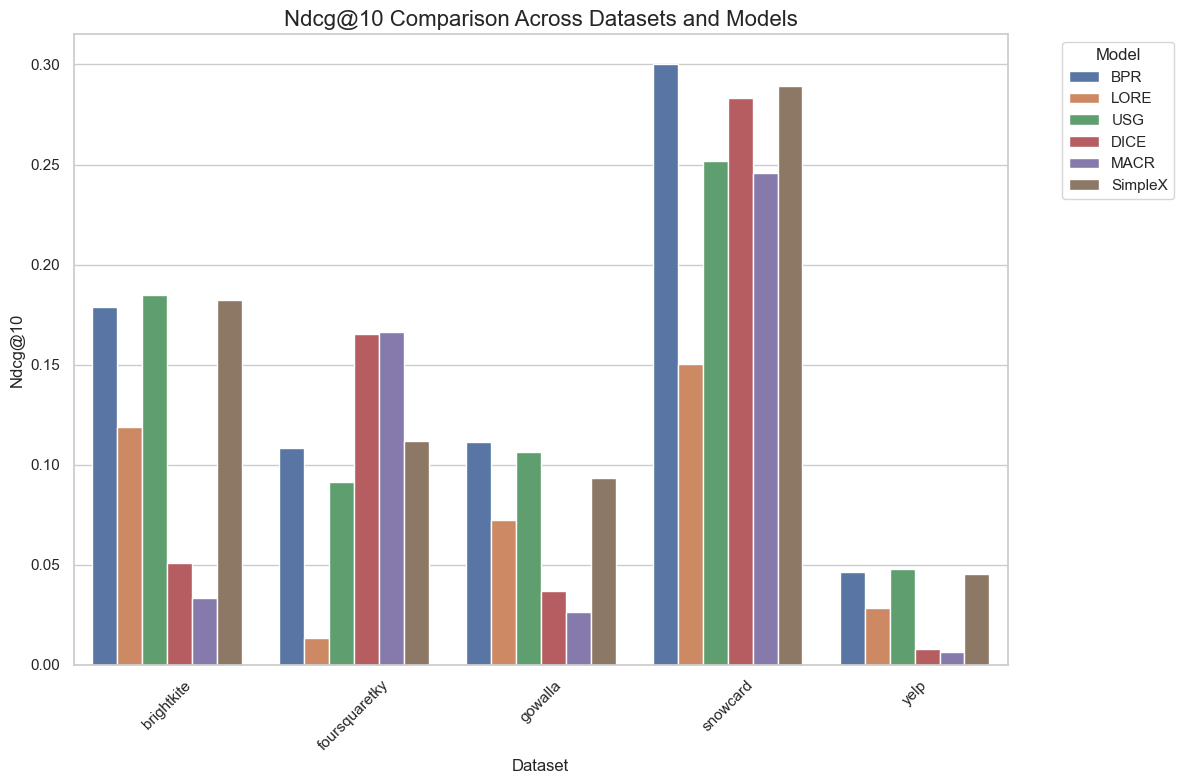

In [166]:

# Set plot style
sns.set(style="whitegrid")

# Plot NDCG@10 values for different models across datasets
plt.figure(figsize=(12, 8))
sns.barplot(x="dataset", y="ndcg@10", hue="model", data=df, ci=None)

# Add labels and title
plt.title('Ndcg@10 Comparison Across Datasets and Models', fontsize=16)
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Ndcg@10', fontsize=12)
plt.xticks(rotation=45)

# Show plot
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# save
plt.savefig(f"{BASE_DIR}/ndcg@10_comparison.png")

plt.show()



/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_59174/3194896603.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="dataset", y="giniindex@10", hue="model", data=df, ci=None)


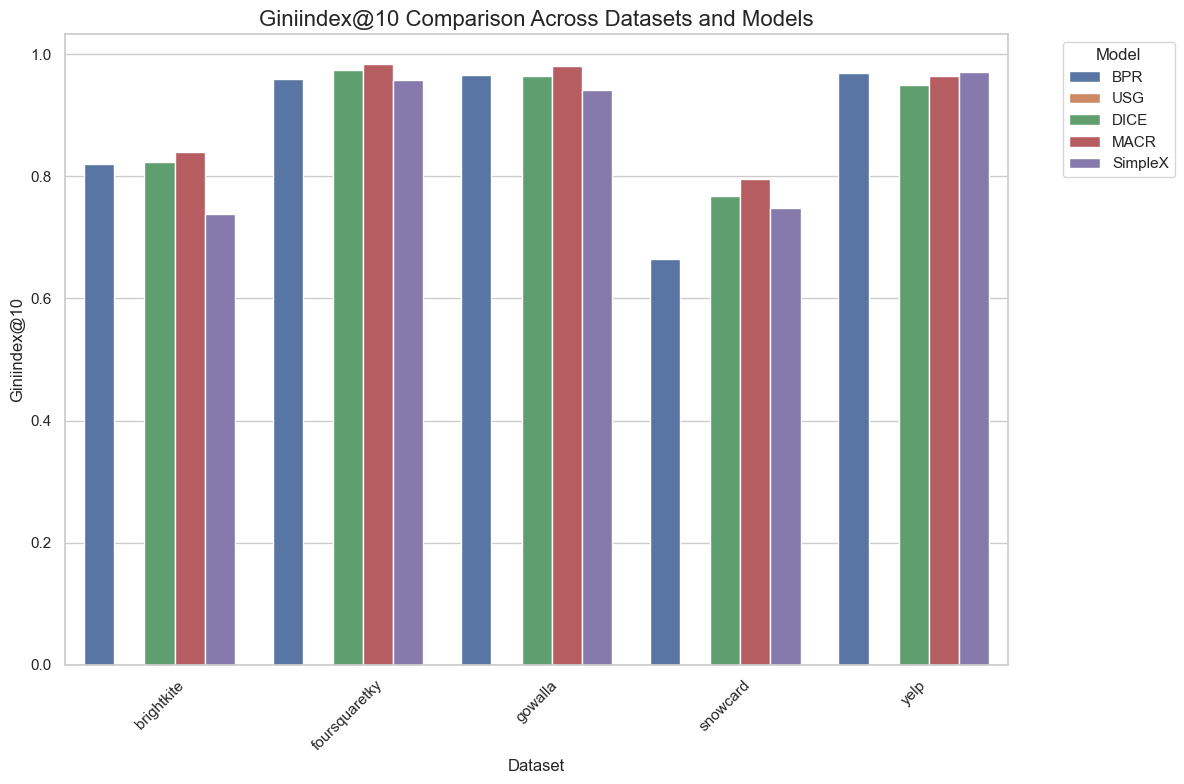

In [153]:
# Set plot style
sns.set(style="whitegrid")

# Plot NDCG@10 values for different models across datasets
plt.figure(figsize=(12, 8))
sns.barplot(x="dataset", y="giniindex@10", hue="model", data=df, ci=None)

# Add labels and title
plt.title('Giniindex@10 Comparison Across Datasets and Models', fontsize=16)
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Giniindex@10', fontsize=12)
plt.xticks(rotation=45)

# Show plot
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# save
plt.savefig(f"{BASE_DIR}/giniindex@10_comparison.png")

plt.show()

In [129]:
# # Ensure columns are numeric
# df['giniindex@10'] = pd.to_numeric(df['giniindex@10'])
# df['ndcg@10'] = pd.to_numeric(df['ndcg@10'])

# # Group by dataset and plot
# for dataset, data in df.groupby('dataset'):
#     plt.figure(figsize=(10, 6))
    
#     # Create a scatter plot
#     scatter_plot = sns.scatterplot( 
#         x='giniindex@10', 
#         y='ndcg@10',
#         data=data, 
#         hue='model',
#         palette='viridis', 
#         s=100,
#         edgecolor='black'
#     )
    
#     # Highlight the best model based on `ndcg@10`
#     best_ndcg = data['ndcg@10'].max()
#     best_model = data.loc[data['ndcg@10'] == best_ndcg, 'model'].values[0]
    
#     plt.title(f'NDCG@10 vs. Gini Index for Each Model - {dataset}')
#     plt.xlabel('Gini Index@10')
#     plt.ylabel('NDCG@10')
    
#     # # Annotate the best model
#     # for i, row in data.iterrows():
#     #     if row['model'] == best_model:
#     #         plt.text(
#     #             row['ndcg@10'], 
#     #             row['giniindex@10'] + 0.01,  # Offset to avoid overlap with the point
#     #             'Best', 
#     #             color='red', 
#     #             ha='center'
#     #         )
    
#     plt.tight_layout()  # Adjust layout to fit labels
#     plt.show()
#     DATASET_DIR = f"/Volumes/Forster Neu/Masterarbeit Data/{dataset}_dataset/"
#     plt.savefig(f'{DATASET_DIR}plots/NDCG@10 vs. Gini Index for Each Model - {dataset}.png', dpi=300)


## Helper Methods 

Popularity bias specific evaluation based on: 
https://github.com/pmuellner/ImpactOfDP/tree/main



In [130]:
# the jaccard distance to measure how the recommendation lists change
def jaccard_distance(x, y):
    return 1 - len(set(x).intersection(y)) / len(set(x).union(y))

# average the results of our evaluation metrics over all seeds
def average_results(results):
    return np.mean([np.mean([results_f[uid] for uid in results_f]) for idx, results_f in enumerate(results)])


def sort_files(path):
    #base, dataset_name, model_name, eps = path.split(sep="/")
    files = []
    for file in os.listdir(path):
        if file.endswith("top_k_recommendations.json"):
            files.append(file)

    return files


# compute the evaluation metrics, i.e., recall, arp, and popularity lift
def _compute_metrics(recommendation_list, item_popularity, groundtruth, user_profile_popularity, impacted_users=None):
    recall, arp, upp = dict(), dict(), dict()
    poplift = []
    
    for uid, recs in recommendation_list.items():
        if impacted_users is not None and uid not in impacted_users:
            continue
        
        # Ensure item IDs end with 'x' and update the list
        recs = [item_id if item_id[-1] == "x" else item_id + "x" for item_id in recs]
        
        # Calculate recall
        recall[uid] = len(groundtruth.loc[uid].intersection([str(iid) for iid in recs])) / len(groundtruth.loc[uid])
        
        # Calculate ARP (average relevance position)
        arp[uid] = np.mean([item_popularity.loc[str(item_id)] for item_id in recs])
        
        # Get user profile popularity
        upp[uid] = user_profile_popularity.loc[uid]
    
    # Calculate poplift
    poplift.append((np.mean(list(arp.values())) - np.mean(list(upp.values()))) / np.mean(list(upp.values())))
    
    return recall, arp, np.mean(poplift)



# compute evaluation metrics across different seeds/files
def _analyze_recommendations(dirpath, item_popularity, groundtruth, user_profile_popularity, impacted_users=None):
    files = sort_files(dirpath)
    recalls, arps, poplifts = [], [], []
    for idx, file in enumerate(files):
        with open(dirpath + "/" + file, "rb") as f:
            recommendation_list = json.load(f)
            recommendation_list = preprocess_recommendations(recommendation_list)
         
        if impacted_users is not None:
            recall, arp, poplift = _compute_metrics(recommendation_list, item_popularity, groundtruth, user_profile_popularity, impacted_users=impacted_users[idx])
            
        else:
            recall, arp, poplift = _compute_metrics(recommendation_list, item_popularity, groundtruth, user_profile_popularity)

        recalls.append(recall)
        arps.append(arp)
        poplifts.append(poplift)


    return recalls, arps, poplifts

def preprocess_recommendations(recommendation_dict):
    """ Preprocess recommendations to extract only the top-k item ids and add 'x' if missing """
    transformed_recommendations = {}

    print(recommendation_dict)

    print(recommendation_dict.items())
    for user, recommendations in recommendation_dict.items():
        item_ids = recommendations[0]['item_id']
        item_ids_array = np.array(item_ids, dtype='<U6')


        transformed_recommendations[user] = item_ids_array[:10]  # limit to k=10

    return transformed_recommendations




# obtain the set of impacted user (per seed/file)
def _get_impacted_users(dirpath_general, dirpath_debias):
    files_general = sort_files(dirpath_general)
    files_debias = sort_files(dirpath_debias)

    impacted_users, frac_impacted_users, avg_dist = [], [], []
    for file_general, file_debias in zip(files_general, files_debias):
        with open(dirpath_general + "/" + file_general, "rb") as f:
            recommendation_list_general = json.load(f)
            recommendation_list_general = preprocess_recommendations(recommendation_list_general)

        with open(dirpath_debias + "/" + file_debias, "rb") as f:
            recommendation_list_debias = json.load(f)
            recommendation_list_debias = preprocess_recommendations(recommendation_list_debias)

        impacted_users_f, dist_f = [], []
        for uid, recs_debias in recommendation_list_debias.items():
            recs_general = recommendation_list_general[uid]

            dist = jaccard_distance(recs_general, recs_debias)
            if dist > 0:
                impacted_users_f.append(uid)
                dist_f.append(dist)

        frac_impacted_users.append(len(impacted_users_f) / len(recommendation_list_debias))
        impacted_users.append(impacted_users_f)
        dist_f = dist_f if len(dist_f) > 0 else 0
        avg_dist.append(np.mean(np.nanmean(dist_f)))
    return impacted_users, np.mean(frac_impacted_users), np.mean(avg_dist)


# Define a function to filter models by dataset and type (general or debias)
def filter_models(data, dataset_name, model_type):
    return [model for model in data if model['dataset'] == dataset_name and model['model_type'] == model_type]

## Calculate Metrics for Different General vs. debias Algorithms

In [131]:
# the main evaluation method, calculates all evaluation metrics for a specific model
def analyze(dataset_name, model_type2, model_type1, groundtruth, user_profile_popularity, item_popularity):
    dir_type2 = BASE_DIR + dataset_name + "_dataset/recommendations/" + model_type2 + "/"
    dir_type1 = BASE_DIR + dataset_name + "_dataset/recommendations/" + model_type1 + "/"
    
    results_type1 = _analyze_recommendations(dirpath=dir_type1, item_popularity=item_popularity, user_profile_popularity=user_profile_popularity, groundtruth=groundtruth)
    recall_type1, arp_type1, poplift_type1 = results_type1

    print("General Recommender: %.4f (recall), %.4f (arp), %.4f (poplift)" % (average_results(recall_type1), average_results(arp_type1), np.mean(poplift_type1)))

    users, frac_impacted, jacc = _get_impacted_users(dirpath_general=dir_type1, dirpath_debias=dir_type2)
    print(f"Number of impacted users: {frac_impacted * 100:.2f}%")
     
    results_type2 = _analyze_recommendations(dirpath=dir_type2, item_popularity=item_popularity, groundtruth=groundtruth, user_profile_popularity=user_profile_popularity, impacted_users=users)
    recall_type2, arp_type2, poplift_type2 = results_type2

    print("Debias Recommender: %.4f (recall), %.4f (arp), %.4f (poplift)" % (average_results(recall_type2), average_results(arp_type2), np.mean(poplift_type2)))

    # delta metrics are calculated per seed/file and averaged afterwards
    delta_recall_type2, delta_arp_type2, delta_poplift_type2 = [], [], []
    for file_idx in range(len(users)):
        delta_recall_type2_f, delta_arp_type2_f = [], []
        for uid in recall_type2[file_idx].keys():
            delta_recall_type2_f.append((recall_type2[file_idx][uid] - recall_type1[file_idx][uid]) / recall_type1[file_idx][uid] if recall_type1[file_idx][uid] != 0 else np.nan)
            delta_arp_type2_f.append((arp_type2[file_idx][uid] - arp_type1[file_idx][uid]) / arp_type1[file_idx][uid] if arp_type1[file_idx][uid] != 0 else np.nan)
        delta_recall_type2.append(100 * np.nanmean(delta_recall_type2_f))
        delta_arp_type2.append(100 * np.nanmean(delta_arp_type2_f))
        delta_poplift_type2.append(100 * (poplift_type2[file_idx] - poplift_type1[file_idx]) / poplift_type1[file_idx])

    evaluated_models = {}
    evaluated_models["model_type1"] = model_type2
    evaluated_models["model_type2"] = model_type1

    print("---> Results: %f%% (recall), %f%% (arp), %f%% (poplift), %f (No. Users), %f (Jacc)" % (
        delta_recall_type2[-1], delta_arp_type2[-1], delta_poplift_type2[-1], 100 * frac_impacted, jacc))


    return delta_recall_type2, delta_arp_type2, delta_poplift_type2, evaluated_models


# wrapper for the evaluation, calls the analyze function individually for each model
def get_results(dataset_name, model_type1, model_type2):
    # Load the test dataset
    test_df = pd.read_csv(f"{BASE_DIR}{dataset_name}_dataset/processed_data_recbole_debias/{dataset_name}_sample.test.inter", sep="\t")
    test_df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
    test_df["user_id"] = test_df["user_id"].astype(str)
    test_df["item_id"] = test_df["item_id"].astype(str)

    test_df['item_id'] = test_df['item_id'].apply(lambda x: x if x[-1] == 'x' else x + 'x')
    test_df['user_id'] = test_df['user_id'].apply(lambda x: x if x[-1] == 'x' else x + 'x')

    groundtruth = test_df.groupby("user_id")["item_id"].apply(set)  
    

    # Load the interaction dataset to compute item popularity and user profile popularity
    df = pd.read_csv(f"{BASE_DIR}{dataset_name}_dataset/processed_data_recbole/{dataset_name}_sample.inter", sep="\t")
    df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
    df["user_id"] = df["user_id"].astype(str)
    df["item_id"] = df["item_id"].astype(str)
    
    df['item_id'] = df['item_id'].apply(lambda x: x if x[-1] == 'x' else x + 'x')
    df['user_id'] = df['user_id'].apply(lambda x: x if x[-1] == 'x' else x + 'x')

    df["user_id"] = df["user_id"].astype(str)
    df["item_id"] = df["item_id"].astype(str)
    

    # Compute item popularity
    item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()
    

    # Compute user profile popularity
    user_profile_pop = df.groupby("user_id")["item_id"].apply(list).apply(
        lambda iids: np.mean([item_popularity.loc[iid] for iid in iids]))
    


    for id in df["item_id"].unique():
        if id[-1] != "x":
            print(id)


    recall_a, arp_a, poplift_a, evaluated_models = analyze(
        dataset_name=dataset_name, 
        model_type2=model_type2,
        model_type1=model_type1,  
        groundtruth=groundtruth, 
        user_profile_popularity=user_profile_pop, 
        item_popularity=item_popularity
    )

    return float(recall_a[0]), float(arp_a[0]), float(arp_a[0]), evaluated_models, item_popularity.index


In [132]:
def compare_model_groups(dataset, group1, group2, label1, label2):
    comparisons = []
    
    # Compare each model from group1 with each model from group2
    for model1 in group1:
        for model2 in group2:
            recall, arp, poplift, evaluated_models, item = get_results(
                dataset_name=dataset,
                model_type1=model1['directory'],
                model_type2=model2['directory'],
            )
            
            # Add result to the list of comparisons
            comparisons.append({
                'dataset': dataset,
                'model1': model1['model'],
                'model2': model2['model'],
                'group1': label1,
                'group2': label2,
                'recall': recall,
                'arp': arp,
                'poplift': poplift,
                'evaluated_models': evaluated_models,
                'item': item
            })
    return comparisons

datasets = ["brightkite"]

all_comparisons = []

for dataset in datasets:
    general_models = filter_models(data, dataset, "general")
    debias_models = filter_models(data, dataset, "debias")
    contextpoi_models = filter_models(data, dataset, "contextpoi")
    
    # Compare general vs debias
    all_comparisons.extend(compare_model_groups(dataset, general_models, debias_models, "general", "debias"))
    
    # Compare general vs contextpoi
    all_comparisons.extend(compare_model_groups(dataset, general_models, contextpoi_models, "general", "contextpoi"))
    
    # Compare debias vs contextpoi
    all_comparisons.extend(compare_model_groups(dataset, contextpoi_models, debias_models, "contextpoi", "debias",))

# Convert the list of comparisons to a pandas DataFrame
df_comparisons = pd.DataFrame(all_comparisons)


General Recommender: 0.0169 (recall), 0.0312 (arp), -0.4466 (poplift)
Number of impacted users: 100.00%
Debias Recommender: 0.0682 (recall), 0.0744 (arp), 0.3187 (poplift)
---> Results: -65.789474% (recall), 145.193307% (arp), -171.361248% (poplift), 100.000000 (No. Users), 0.989786 (Jacc)
General Recommender: 0.0169 (recall), 0.0312 (arp), -0.4466 (poplift)
Number of impacted users: 100.00%
Debias Recommender: 0.0455 (recall), 0.0824 (arp), 0.4599 (poplift)
---> Results: -88.596491% (recall), 171.862459% (arp), -202.991271% (poplift), 100.000000 (No. Users), 0.990390 (Jacc)
General Recommender: 0.0169 (recall), 0.0312 (arp), -0.4466 (poplift)
Number of impacted users: 100.00%
Debias Recommender: 0.0257 (recall), 0.0880 (arp), 0.5584 (poplift)
---> Results: -89.473684% (recall), 189.778634% (arp), -225.036639% (poplift), 100.000000 (No. Users), 0.989844 (Jacc)
General Recommender: 0.0151 (recall), 0.0319 (arp), -0.4356 (poplift)
Number of impacted users: 100.00%
Debias Recommender: 0.0

In [133]:
df_comparisons = df_comparisons[['dataset', 'model1', 'model2', 'group1', 'group2', 'recall', 'arp', 'poplift']]

In [134]:
df_comparisons

,dataset,model1,model2,group1,group2,recall,arp,poplift
0,brightkite,BPR,DICE,general,debias,-65.789474,145.193307,145.193307
1,brightkite,BPR,MACR,general,debias,-88.596491,171.862459,171.862459
2,brightkite,BPR,PDA,general,debias,-89.473684,189.778634,189.778634
3,brightkite,ItemKNN,DICE,general,debias,-65.740741,144.401607,144.401607
4,brightkite,ItemKNN,MACR,general,debias,-74.074074,170.640751,170.640751
5,brightkite,ItemKNN,PDA,general,debias,-81.481481,188.632843,188.632843
6,brightkite,SimpleX,DICE,general,debias,-58.510638,148.000380,148.000380
7,brightkite,SimpleX,MACR,general,debias,-77.659574,174.360406,174.360406
8,brightkite,SimpleX,PDA,general,debias,-82.978723,192.964868,192.964868
9,brightkite,BPR,LORE,general,contextpoi,-85.964912,4.160906,4.160906


In [135]:
df_comparisons = df_comparisons.round(5)
df_comparisons.to_csv(f"{BASE_DIR}/evaluation_results_delta_comparisons.csv", index=False)

In [136]:
df_comparisons

,dataset,model1,model2,group1,group2,recall,arp,poplift
0,brightkite,BPR,DICE,general,debias,-65.78947,145.19331,145.19331
1,brightkite,BPR,MACR,general,debias,-88.59649,171.86246,171.86246
2,brightkite,BPR,PDA,general,debias,-89.47368,189.77863,189.77863
3,brightkite,ItemKNN,DICE,general,debias,-65.74074,144.40161,144.40161
4,brightkite,ItemKNN,MACR,general,debias,-74.07407,170.64075,170.64075
5,brightkite,ItemKNN,PDA,general,debias,-81.48148,188.63284,188.63284
6,brightkite,SimpleX,DICE,general,debias,-58.51064,148.00038,148.00038
7,brightkite,SimpleX,MACR,general,debias,-77.65957,174.36041,174.36041
8,brightkite,SimpleX,PDA,general,debias,-82.97872,192.96487,192.96487
9,brightkite,BPR,LORE,general,contextpoi,-85.96491,4.16091,4.16091


In [137]:
# # List of datasets in your models
# datasets = ["gowalla", "brightkite", "foursquaretky", "yelp", "snowcard"]

# results = []

# # Loop through each dataset and compare general vs debias models
# for dataset in datasets:
#     general_models = filter_models(data, dataset, "general")
#     debias_models = filter_models(data, dataset, "contextpoi")
    

#     # Compare each general model with each debias model in the same dataset
#     for general_model in general_models:
#         for debias_model in debias_models:
#             print(f"{general_model['model']} vs. {debias_model['model']} ({dataset})")
#             recall, arp, poplift, evaluated_models, item = get_results(
#                 dataset_name=dataset, 
#                 model_type1=general_model['directory'], 
#                 model_type2=debias_model['directory'],
#             )

    
#             print("-" * 50)









In [138]:

def _analyze_poplift_usergroups(dataset_name, model_name):
    def _compute_poplift(dirpath, item_popularity, user_profile_popularity, group):
        files = sort_files(dirpath)
        poplifts = []
        for idx, file in enumerate(files):
            with open(dirpath + "/" + file, "rb") as f:
                recommendation_list = json.load(f)
                recommendation_list = preprocess_recommendations(recommendation_list)
                arp_g, upp_g = [], []
                for uid, recs in recommendation_list.items():
                    if uid not in group[idx]:
                        continue

                    recs = [item_id if item_id[-1] == "x" else item_id + "x" for item_id in recs]

                    arp_g.append(np.mean([item_popularity.loc[str(iid)] for iid in recs]))
                    upp_g.append(user_profile_popularity.loc[uid])

                poplifts.append((np.mean(arp_g) - np.mean(upp_g)) / np.mean(upp_g))
        return np.mean(poplifts)

    # Load user group data
    with open(f"{BASE_DIR}/{dataset_name}_dataset/{dataset_name}_user_id_popularity.json", "r") as f:
        user_groups = json.load(f)

    # Load interaction data and compute item/user popularity
    df = pd.read_csv(f"{BASE_DIR}{dataset_name}_dataset/processed_data_recbole/{dataset_name}_sample.inter", sep="\t")
    df.rename(columns={"user_id:token": "user_id", "item_id:token": "item_id"}, inplace=True)
    df["user_id"] = df["user_id"].astype(str)
    df["item_id"] = df["item_id"].astype(str)
    
    # Append 'x' to IDs if needed
    df['item_id'] = df['item_id'].apply(lambda x: x if x[-1] == 'x' else x + 'x')
    df['user_id'] = df['user_id'].apply(lambda x: x if x[-1] == 'x' else x + 'x')

    # Compute item popularity
    item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

    # Compute user profile popularity
    user_profile_pop = df.groupby("user_id")["item_id"].apply(list).apply(
        lambda iids: np.mean([item_popularity.loc[iid] for iid in iids]))

    # Get user groups
    low_users = user_groups["low"]
    medium_users = user_groups["medium"]
    high_users = user_groups["high"]

    # Directory for recommendations
    dir = BASE_DIR + dataset_name + "_dataset/recommendations/" + model_name + "/"

    # Compute PopLift for low, medium, and high user groups
    pl_low = _compute_poplift(dirpath=dir, item_popularity=item_popularity, user_profile_popularity=user_profile_pop, group=low_users)
    pl_medium = _compute_poplift(dirpath=dir, item_popularity=item_popularity, user_profile_popularity=user_profile_pop, group=medium_users)
    pl_high = _compute_poplift(dirpath=dir, item_popularity=item_popularity, user_profile_popularity=user_profile_pop, group=high_users)

    # Store results in a dictionary
    result = {
        'dataset': dataset_name,
        'model': model_name,
        'poplift_low': pl_low,
        'poplift_medium': pl_medium,
        'poplift_high': pl_high,
        'gap_low_high': np.abs(pl_low - pl_high),
        'gap_low_medium': np.abs(pl_low - pl_medium),
        'gap_medium_high': np.abs(pl_medium - pl_high)
    }
    
    return result


In [139]:
results = []

for dataset in datasets:
    general_models = filter_models(data, dataset, "general")
    debias_models = filter_models(data, dataset, "debias")
    contextpoi_models = filter_models(data, dataset, "contextpoi")
    
    # Compare each general model with each debias model in the same dataset
    for general_model in general_models:
        result = _analyze_poplift_usergroups(dataset_name=dataset, model_name=general_model["directory"])
        results.append(result)

    for debias_model in debias_models:
        result = _analyze_poplift_usergroups(dataset_name=dataset, model_name=debias_model["directory"])
        results.append(result)

    for contextpoi_model in contextpoi_models:
        result = _analyze_poplift_usergroups(dataset_name=dataset, model_name=contextpoi_model["directory"])
        results.append(result)
    

In [140]:
for result in results:
    result["dataset"] = result["model"].split("_")[0]

    result["model_clean"] = result["model"].split("-")[1]
    if result["model"].split("-")[1] in ["debias", "contextpoi"]:
        result["model_clean"] = result["model"].split("-")[2]

poplift_gap_results = pd.DataFrame(results)
poplift_gap_results.drop(columns=["model"], inplace=True)
poplift_gap_results.rename(columns={"model_clean": "model"}, inplace=True)
poplift_gap_results = poplift_gap_results[['dataset', 'model', 'poplift_low', 'poplift_medium', 'poplift_high', 'gap_low_high', 'gap_low_medium', 'gap_medium_high']]
poplift_gap_results = poplift_gap_results.round(5)
poplift_gap_results.to_csv(f"{BASE_DIR}/evaluation_poplift_gap_results.csv", index=False)


In [141]:
poplift_gap_results

,dataset,model,poplift_low,poplift_medium,poplift_high,gap_low_high,gap_low_medium,gap_medium_high
0,brightkite,BPR,-0.30487,-0.49644,-0.50129,0.19642,0.19158,0.00485
1,brightkite,ItemKNN,-0.27912,-0.36730,-0.36461,0.08549,0.08818,0.00269
2,brightkite,SimpleX,-0.32359,-0.36359,-0.55580,0.23221,0.04000,0.19221
3,brightkite,DICE,0.40782,0.09630,-0.11078,0.51860,0.31152,0.20709
4,brightkite,MACR,0.78347,0.11860,-0.08963,0.87310,0.66487,0.20823
5,brightkite,PDA,1.02923,0.28305,0.18779,0.84143,0.74618,0.09525
6,brightkite,LORE,-0.36572,-0.43234,-0.53546,0.16974,0.06662,0.10312
7,brightkite,USG,-0.37625,-0.44256,-0.53139,0.15514,0.06631,0.08883
